# Lotka-Volterra toy model

The [LotkaVolterraModel](http://pints.readthedocs.io/en/latest/toy/lotka_volterra_model.html) describes the relationship between two interacting species, where one preys on the other. A good description of its history and interpretation can be found on [Wikipedia](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations).

The model has 2 states $x$ and $y$, where $x$ represents a population of prey, and $y$ represents a population of predators.
It is described by the ODEs:

$$ \frac{dx}{dt} = ax - bxy $$

and

$$ \frac{dy}{dt} = -cy + dxy $$

where $a, b, c$, and $d$ are the four model parameters.

In [4]:
import pints
import pints.toy

model = pints.toy.LotkaVolterraModel()

print('Outputs: ' + str(model.n_outputs()))
print('Parameters: ' + str(model.n_parameters()))

Outputs: 2
Parameters: 4


The model comes pre-packaged with lynx-hare pelt count data collected by the Hudson's
Bay Company in Canada in the early twentieth century, which is taken
from [1]. The data given here corresponds to annual observations
taken from 1900-1920 (inclusive). We now plot this data.

[1] Howard, P. (2009). Modeling basics. Lecture Notes for Math 442,
           Texas A&M University

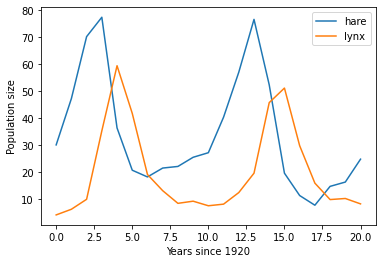

[[30.   4. ]
 [47.2  6.1]
 [70.2  9.8]
 [77.4 35.2]
 [36.3 59.4]
 [20.6 41.7]
 [18.1 19. ]
 [21.4 13. ]
 [22.   8.3]
 [25.4  9.1]
 [27.1  7.4]
 [40.3  8. ]
 [57.  12.3]
 [76.6 19.5]
 [52.3 45.7]
 [19.5 51.1]
 [11.2 29.7]
 [ 7.6 15.8]
 [14.6  9.7]
 [16.2 10.1]
 [24.7  8.1]]


In [5]:
times = model.suggested_times()
values = model.suggested_values()

import matplotlib.pyplot as plt
plt.figure()
plt.xlabel('Years since 1920')
plt.ylabel('Population size')
plt.plot(times, values)
plt.legend(['hare', 'lynx'])
plt.show()

print(values)


In this set-up, the first state represents the prey, and the second the predators.
When there is no prey, the predators begin to die out, which allows the prey population to recover.

To show the cyclical nature more clearly, these two populations are often plotted against each other:

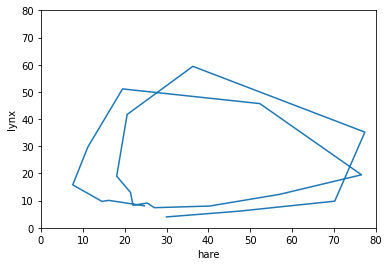

In [3]:
plt.figure()
plt.xlim(0, 80)
plt.ylim(0, 80)
plt.xlabel('hare')
plt.ylabel('lynx')
plt.plot(values[:, 0], values[:, 1])
plt.show()

We now use PINTS to fit the Lotka-Volterra model (with fixed initial conditions $[x,y]=[30, 4]$) to the pelts data on lynxs and hares. Previous work has showed that a multiplicative noise model is more appropriate to fit these data [2]. As such, we fit the model to the log of the series.

[2] Predator-Prey Population Dynamics: the Lotka-Volterra model in Stan. Carpenter, B. https://mc-stan.org/users/documentation/case-studies/lotka-volterra-predator-prey.html

In [4]:
import numpy as np

# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, np.log(values))

# Create a log posterior
log_prior_theta = pints.UniformLogPrior(lower_or_boundaries=0, upper=2)
log_prior_sigma = pints.GaussianLogPrior(mean=0, sd=3)
log_prior = pints.ComposedLogPrior(log_prior_theta, log_prior_theta, log_prior_theta, log_prior_theta,
                                   log_prior_sigma, log_prior_sigma)
log_likelihood = pints.GaussianLogLikelihood(problem)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Run MCMC on the noisy data
x0 = [[0.43, 0.16, 0.9, 0.27, 0.28, 0.26]] * 4
mcmc = pints.MCMCController(log_posterior, 4, x0)
mcmc.set_max_iterations(4000)

chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0         0         0         0          0:00.0
2     12     0         0         0.333     0          0:00.0
3     16     0         0         0.25      0          0:00.0
20    84     0.0476    0         0.0476    0          0:00.1
40    164    0.0244    0         0.0976    0          0:00.2
60    244    0.0164    0         0.0656    0          0:00.3
80    324    0.0123    0         0.0617    0.0123     0:00.3
100   404    0.0396    0.0099    0.0495    0.0099     0:00.4
120   484    0.0331    0.0165    0.0413    0.00826    0:00.5
140   564    0.0284    0.0213    0.0355    0.0142     0:00.6
160   644    0.0311    0.0186    0.0311    0.0124     0:00.6
180   724    0.0276    0.0166    0.0276    0.011      0:00.7
Initial phase completed.
200   804    0.0249    0.

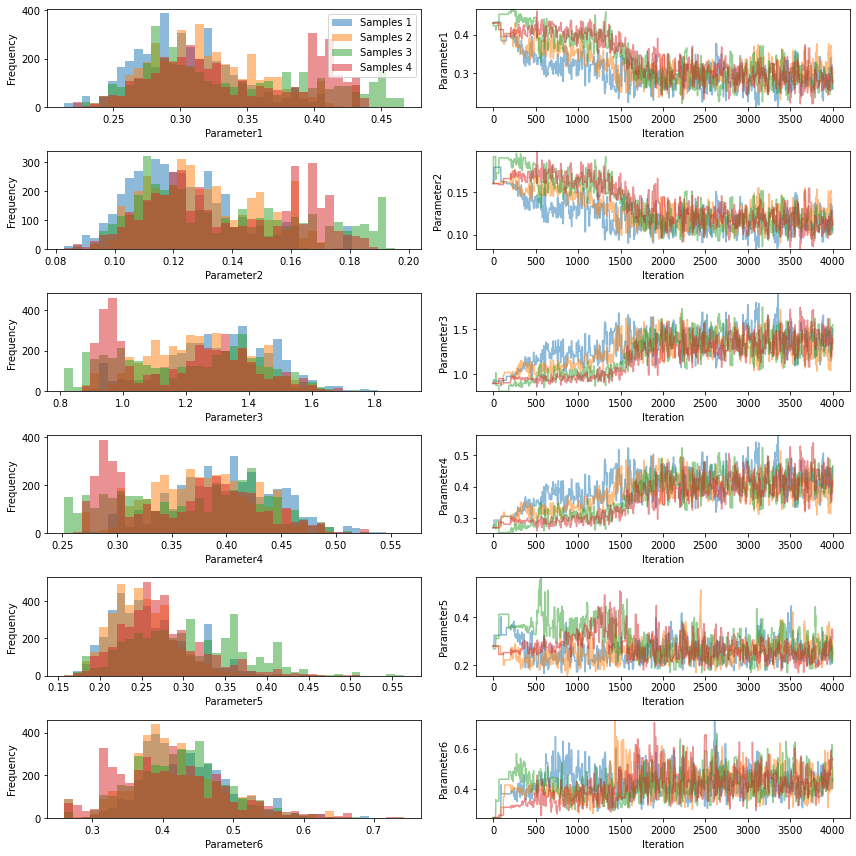

In [5]:
import pints.plot
pints.plot.trace(chains)
plt.show()

In [6]:
results = pints.MCMCSummary(
    chains=chains, 
    parameter_names=["a", "b", "c", "d", "sigma_1", "sigma_2"], 
    time=mcmc.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
a        0.33    0.05    0.25    0.29   0.32   0.36   0.44     1.47    19.11   1.17
b        0.13    0.02    0.10    0.11   0.13   0.15   0.18     1.46    18.95   1.16
c        1.23    0.20    0.90    1.07   1.25   1.38   1.58     1.43    19.84   1.22
d        0.38    0.06    0.27    0.33   0.38   0.42   0.48     1.42    20.26   1.24
sigma_1  0.27    0.06    0.19    0.23   0.26   0.30   0.41     1.22    105.42  6.47
sigma_2  0.42    0.07    0.30    0.38   0.42   0.46   0.58     1.06    111.39  6.83


We can also compare the predictions with these values to what we found: looks like a reasonable fit.

In [7]:
chains[0][-1]

array([0.25976837, 0.10479854, 1.49870635, 0.46179747, 0.25414642,
       0.45202113])

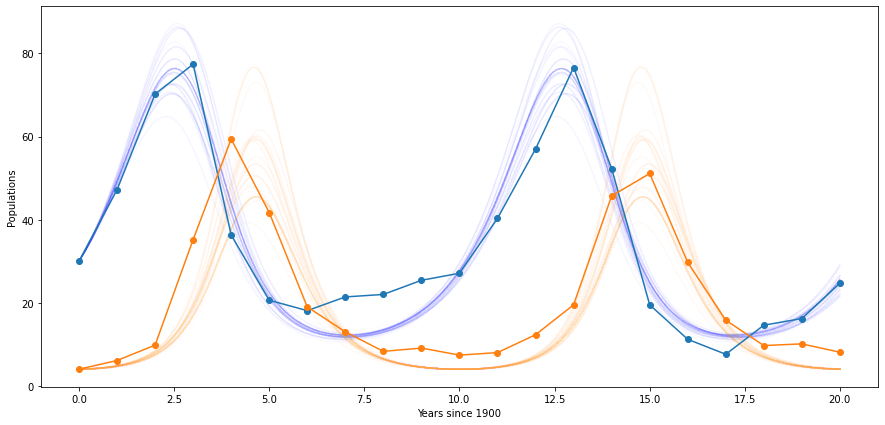

In [8]:
# Select first chain
chain1 = chains[0]

# Remove warm up period
chain1 = chain1[500:]

# Create fine-grained list of times for plotting
n_fine = 1000
times_fine = np.linspace(min(times), max(times), n_fine)

# Plot some predictions with these samples
num_lines = 100
hare = np.zeros((n_fine, num_lines))
lynx = np.zeros((n_fine, num_lines))
for i in range(num_lines):
    temp = np.exp(model.simulate(times=times_fine, parameters=chain1[i, :4]))
    hare[:, i] = temp[:, 0]
    lynx[:, i] = temp[:, 1]
plt.figure(figsize=(15, 7))
plt.xlabel('Years since 1900')
plt.ylabel('Populations')
plt.plot(times_fine, hare, color='blue', alpha=0.01)
plt.plot(times_fine, lynx, color='orange', alpha=0.01)
plt.plot(times, values, 'o-')
plt.show()

Since this is a tricky model to fit, let's use HMC to fit the same data.

In [9]:
# Run MCMC on the noisy data
x0 = [[0.43, 0.16, 0.9, 0.27, 0.28, 0.26]] * 4
mcmc = pints.MCMCController(log_posterior, 4, x0, method=pints.HamiltonianMCMC)
mcmc.set_max_iterations(200)
mcmc.set_log_interval(1)

for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size([0.1, 0.01, 0.1, 0.03, 0.05, 0.05])
    sampler.set_leapfrog_steps(10)

chains = mcmc.run()

Using Hamiltonian Monte Carlo
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     44     0.333     0.333     0         0          0:00.4
2     84     0.5       0.25      0.25      0          0:00.8
3     124    0.4       0.4       0.4       0.2        0:01.2
4     164    0.333     0.5       0.333     0.333      0:01.6
5     204    0.286     0.571     0.429     0.286      0:01.9
6     244    0.25      0.625     0.5       0.375      0:02.3
7     284    0.333     0.667     0.556     0.444      0:02.7
8     324    0.3       0.6       0.6       0.4        0:03.1
9     364    0.273     0.636     0.545     0.455      0:03.5
10    404    0.25      0.667     0.5       0.417      0:03.8
11    444    0.308     0.692     0.538     0.385      0:04.2
12    484    0.357     0.714     0.5       0.429      0:04.6
13    524    0.4       0.733     0.467     0.467      0:04.9
14    

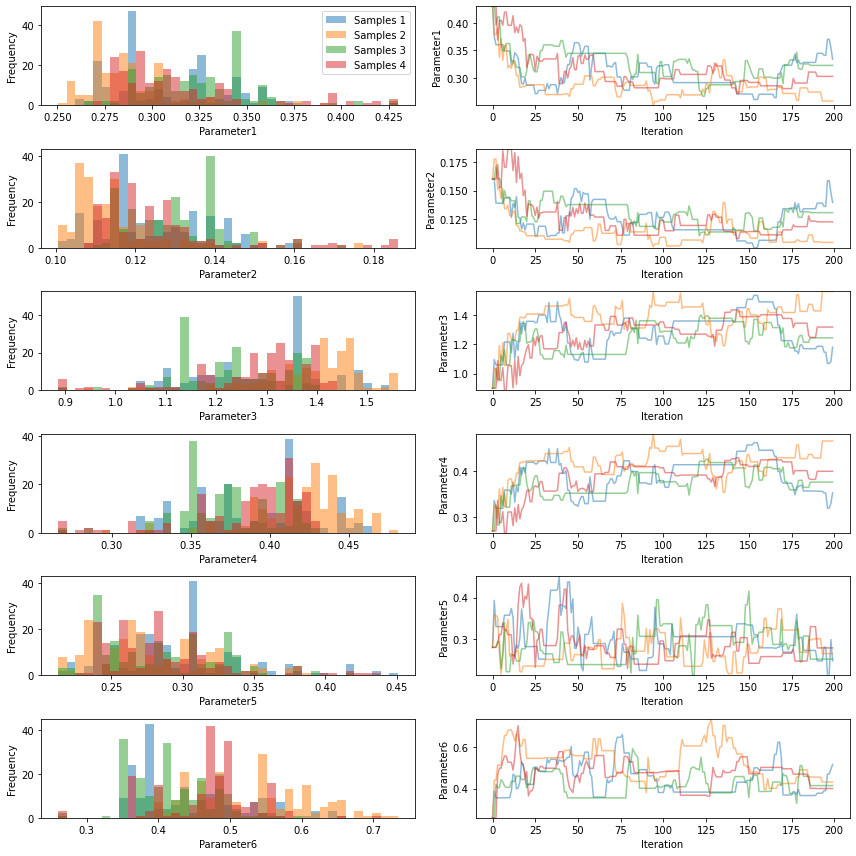

In [10]:
import pints.plot
pints.plot.trace(chains)
plt.show()

We get similar results as with adaptive covariance; except, the efficiency suffers due to having to calculate the sensitivities. Overall, for this problem, adaptive covariance performs favourably.

In [11]:
results = pints.MCMCSummary(
    chains=chains,
    parameter_names=["a", "b", "c", "d", "sigma_1", "sigma_2"],
    time=mcmc.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
a        0.31    0.03    0.26    0.29   0.30   0.33   0.39     1.23    36.86  0.48
b        0.12    0.01    0.10    0.11   0.12   0.13   0.16     1.21    36.35  0.48
c        1.30    0.13    1.04    1.21   1.32   1.38   1.49     1.25    35.96  0.47
d        0.39    0.04    0.31    0.37   0.40   0.42   0.45     1.24    35.06  0.46
sigma_1  0.29    0.04    0.22    0.26   0.28   0.31   0.39     1.06    54.45  0.71
sigma_2  0.46    0.08    0.36    0.40   0.46   0.50   0.65     1.21    65.51  0.86


In [6]:
import numpy as np
from matplotlib import pyplot as plt
import scipy


def dX_dt(X, t):
    a, b, c, d =  0.32, 0.13, 1.27, 0.38
    x, y = X
    dotx = x * (a - b * y)
    doty = y * (-c + d * x)
    return np.array([dotx, doty])

In [13]:
print(values)

[[30.   4. ]
 [47.2  6.1]
 [70.2  9.8]
 [77.4 35.2]
 [36.3 59.4]
 [20.6 41.7]
 [18.1 19. ]
 [21.4 13. ]
 [22.   8.3]
 [25.4  9.1]
 [27.1  7.4]
 [40.3  8. ]
 [57.  12.3]
 [76.6 19.5]
 [52.3 45.7]
 [19.5 51.1]
 [11.2 29.7]
 [ 7.6 15.8]
 [14.6  9.7]
 [16.2 10.1]
 [24.7  8.1]]


/Users/sajai/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/sajai/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/sajai/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/sajai/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


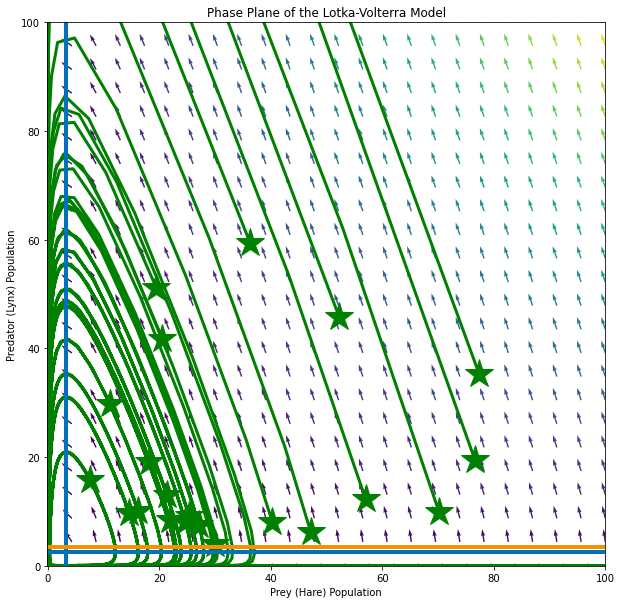

In [18]:
def plot_lotka_volterra_phase_plane():
    a, b, c, d =  0.32, 0.13, 1.27, 0.38
    plt.figure(figsize=(10,10))

    init_x, init_y =  values[:,0], values[:,1]
    
    plt.plot(init_x, init_y, 'g*', markersize=30)

    for v in values:
        X0 = v                          # starting point
        X = scipy.integrate.odeint( dX_dt, X0, np.linspace(0,80,1000))
        plt.plot( X[:,0], X[:,1], lw=3, color='green')

    # plot nullclines
    x = np.linspace(0, 100, 24)
    y = np.linspace(0, 100, 24)

    plt.hlines(a/b, x.min(), x.max(), color='#F39200', lw=4, label='y-nullcline 1')
    plt.plot(x,(a/b)* np.ones_like(x), color='#0072bd', lw=4, label='x-nullcline 2')
    plt.vlines(c/d, x.min(), x.max(), color='#0072bd', lw=4, label='x-nullcline 1')
    plt.plot(x, (c/d)* np.ones_like(x), color='#F39200', lw=4, label='y-nullcline 2')

    # quiverplot - define a grid and compute direction at each point
    X, Y = np.meshgrid(x, y)  # create a grid
    DX = a * X - b * X * Y  # evaluate dx/dt
    DY = -c * Y + d * X * Y  # evaluate dy/dt
    M = (np.hypot(DX, DY))  # norm growth rate
    M[M == 0] = 1.  # avoid zero division errors

    plt.quiver(X, Y, DX / M, DY / M, M)
    plt.xlim(-0.05, 100)
    plt.ylim(-0.05, 100)
    plt.xlabel('Prey (Hare) Population')
    plt.ylabel('Predator (Lynx) Population')
    plt.title('Phase Plane of the Lotka-Volterra Model')
    plt.show()


plot_lotka_volterra_phase_plane()